## testing notebook 

tsting if altercation on the inputs changes the output

In [1]:
import tensorflow as tf
from skimage.metrics import mean_squared_error, normalized_root_mse,normalized_mutual_information
from sklearn.preprocessing import normalize, MinMaxScaler


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from alive_progress import  alive_bar
import torch
import sys
from pathlib import Path
import os

print(sys.path)
sys.path.append('/root/LatentOE-AD')
from loader.LoadData import CIFAR10_feat , FMNIST_feat
from Additional_Code_BULE.utils.helper_functions  import *
from Additional_Code_BULE.utils.AE_models_TF  import *


print(f'tensorflow_version: {tf.__version__}')
print(f'torch_version: {torch.__version__}')
print("Tensorflow: Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f'GPU for pytorch: {torch.cuda.is_available()}')


DATA_PATH="/root/LatentOE-AD/DATA/fmnist_features/"
modelname='Autoencoder_features_simple_3'
MODEL_SHORT= 'AE3'

2023-07-24 12:41:39.400736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 12:41:39.538859: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 12:41:39.597973: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-24 12:41:40.139935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

['/root/LatentOE-AD/Additional_Code_BULE', '/root/LatentOE-AD/Additional_Code_BULE/c', '/root/LatentOE-AD/Additional_Code_BULE/\\\\Users\\\\buehl\\\\git\\\\projects\\\\LatentOE-AD', '/root/anaconda3/envs/AutencoderTF/lib/python39.zip', '/root/anaconda3/envs/AutencoderTF/lib/python3.9', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/lib-dynload', '', '/root/anaconda3/envs/AutencoderTF/lib/python3.9/site-packages']
tensorflow_version: 2.10.1
torch_version: 2.0.1
Tensorflow: Num GPUs Available:  0
GPU for pytorch: True


2023-07-24 12:41:42.298085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 12:41:42.298276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-07-24 12:41:42.298301: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [69]:
i=0
contam=0.2
epochs=10

x_train, y_train, x_test, y_test = FMNIST_feat(i,root=DATA_PATH,contamination_rate=contam)
x_train=x_train.numpy()
x_test=x_test.numpy()

# # transformation of features train
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train=np.sqrt(scaler.transform(x_train))

# # transformation of features train
scaler = MinMaxScaler()
scaler.fit(x_test)
x_test=np.sqrt(scaler.transform(x_test))


#####  Autoencoder 3
# instantiate model Autoencoder
autoencoder = Autoencoder_features_simple_3()
autoencoder=autoencoder.model()

# fit to data
autoencoder.fit(x_train, x_train,epochs=epochs,shuffle=True,verbose=True)

Epoch 1/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0249
Epoch 2/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0155
Epoch 3/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0128
Epoch 4/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0115
Epoch 5/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0106
Epoch 6/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0102
Epoch 7/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0098
Epoch 8/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0095
Epoch 9/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0093
Epoch 10/10
235/235 [==============================] - 2s 9ms/step - loss: 0.0092


In [70]:

# Filter xtest based on ytes
x_test_normal = x_test[y_test == 0]
x_test_anomaly = x_test[y_test == 1]

In [71]:
def calculate_avg_tensor(x,autoencoder):

    # call the predict function on each copy of the input tensor wit each input having a neuron altered
    x_n = np.tile(x, (x.shape[0], 1, 1))
    for i in range(x_n.shape[0]):
        for j in range(x_n.shape[1]):
            x_n[i,j,i]=1

    tensor_shape = (x.shape[0], x.shape[1])
    output_shape = (x.shape[1], x.shape[0], x.shape[1])
    output_tensor = np.empty(output_shape)

    # Loop through each copy, get the predictions, and store them in the output tensor
    for i in range(x_n.shape[0]):
        prediction = autoencoder.predict(x_n[i, :, :].reshape(-1, x.shape[1]), verbose=False)
        output_tensor[i, :, :] = prediction.reshape(tensor_shape)

    average_tensor = np.mean(output_tensor, axis=0)
    return average_tensor

# Normal data

In [72]:
## calculate average tensor
average_tensor_n=calculate_avg_tensor(x_test_normal,autoencoder)
## get reconstruction with no pertubation
decoded_imgs_n = autoencoder.predict(x_test_normal, verbose=False)

# calculate mse fore each example
mse_recons_n,mse_avg_n=[],[]
for j in range(0,len(decoded_imgs_n)):
    mse_recons_n.append(mean_squared_error(x_test_normal[j],decoded_imgs_n[j]))

for j in range(0,len(decoded_imgs_n)):
    mse_avg_n.append(mean_squared_error(x_test_normal[j],average_tensor_n[j]))   

In [73]:
difference_n=list(np.array(mse_avg_n)-np.array(mse_recons_n))

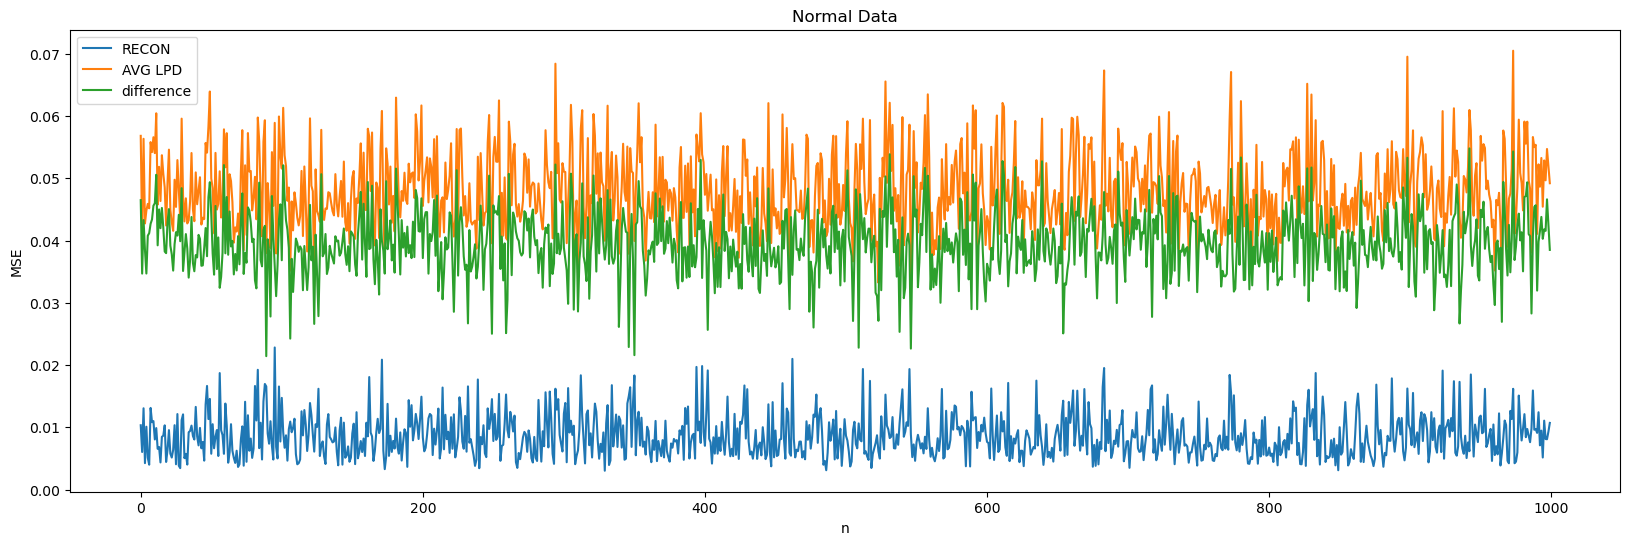

In [74]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
y=np.arange(0,len(mse_recons_n),1)
# Create the line plot
plt.plot(y,mse_recons_n,  label='RECON')
plt.plot(y,mse_avg_n,  label='AVG LPD')
plt.plot(y,difference_n,  label='difference')
# Add labels and title
plt.xlabel('n')
plt.ylabel('MSE')
plt.title('Normal Data')
plt.legend()
# Show the plot
plt.show()

# Anomalous Data

In [75]:
subset=x_test_anomaly[0:1000]

In [76]:
# works for subset of 1000 points
## calculate average tensor
average_tensor_a=calculate_avg_tensor(subset,autoencoder)
## get reconstruction with no pertubation
decoded_imgs_a = autoencoder.predict(subset, verbose=False)

# calculate mse fore each example
mse_recons_a,mse_avg_a=[],[]
for j in range(0,len(decoded_imgs_a)):
    mse_recons_a.append(mean_squared_error(subset[j],decoded_imgs_a[j]))

for j in range(0,len(decoded_imgs_a)):
    mse_avg_a.append(mean_squared_error(subset[j],average_tensor_a[j]))   

In [77]:
difference_a=list(np.array(mse_avg_a)-np.array(mse_recons_a))

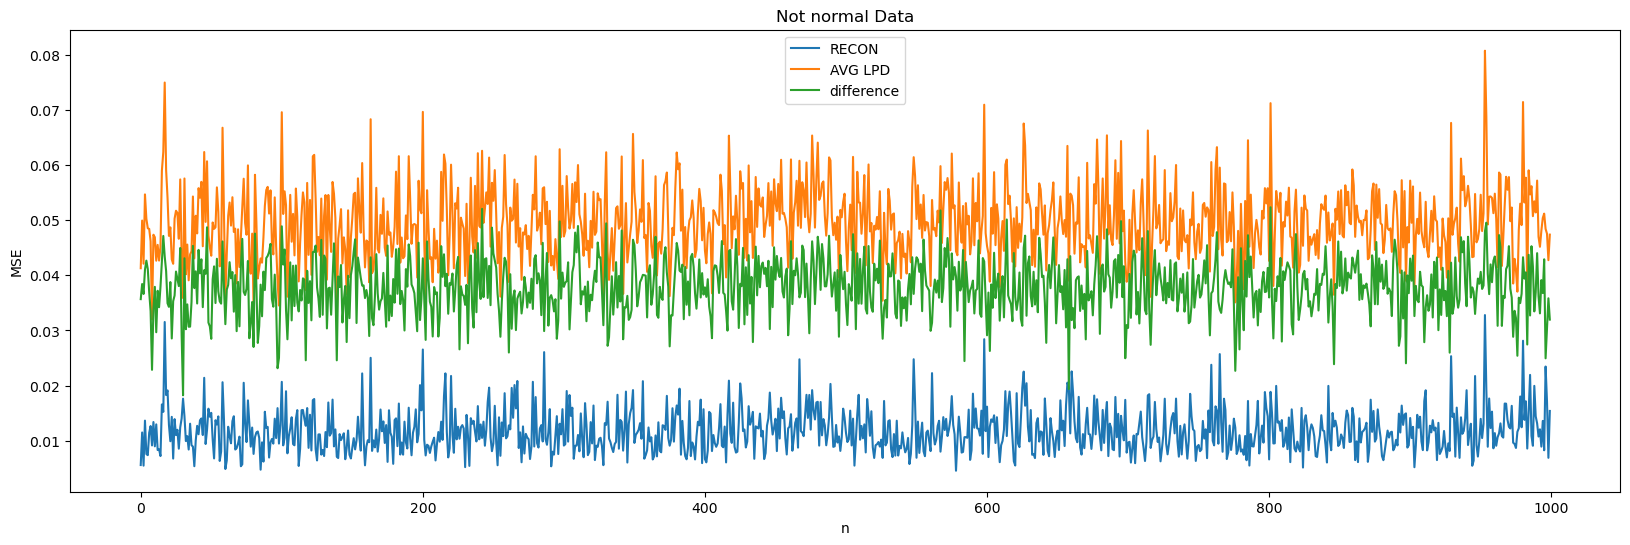

In [78]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
y=np.arange(0,len(mse_recons_a),1)
# Create the line plot
plt.plot(y,mse_recons_a,  label='RECON')
plt.plot(y,mse_avg_a,  label='AVG LPD')
plt.plot(y,difference_a,  label='difference')
# Add labels and title
plt.xlabel('n')
plt.ylabel('MSE')
plt.title('Not normal Data')
plt.legend()
# Show the plot
plt.show()

# anomalous vs normal 

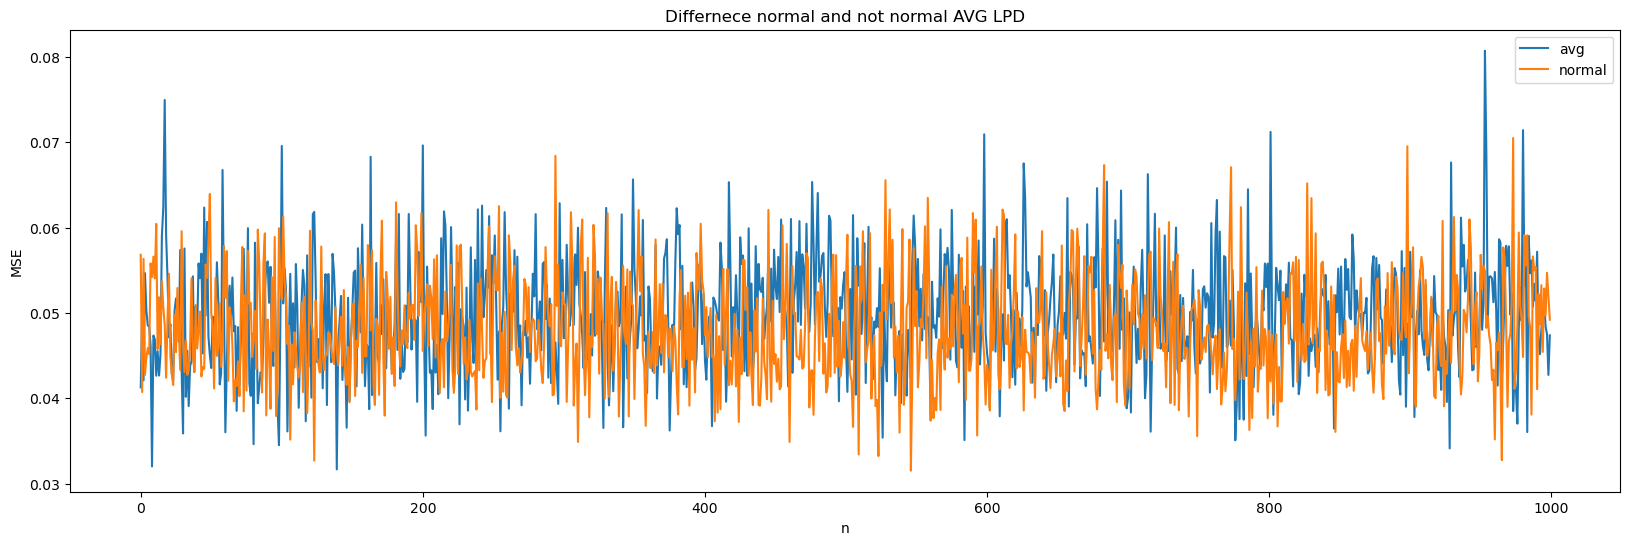

In [79]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
y=np.arange(0,len(mse_recons_a),1)
# Create the line plot

plt.plot(y,mse_avg_a,  label='avg')
plt.plot(y,mse_avg_n,  label='normal')
# Add labels and title
plt.xlabel('n')
plt.ylabel('MSE')
plt.title('Differnece normal and not normal AVG LPD')
plt.legend()
# Show the plot
plt.show()

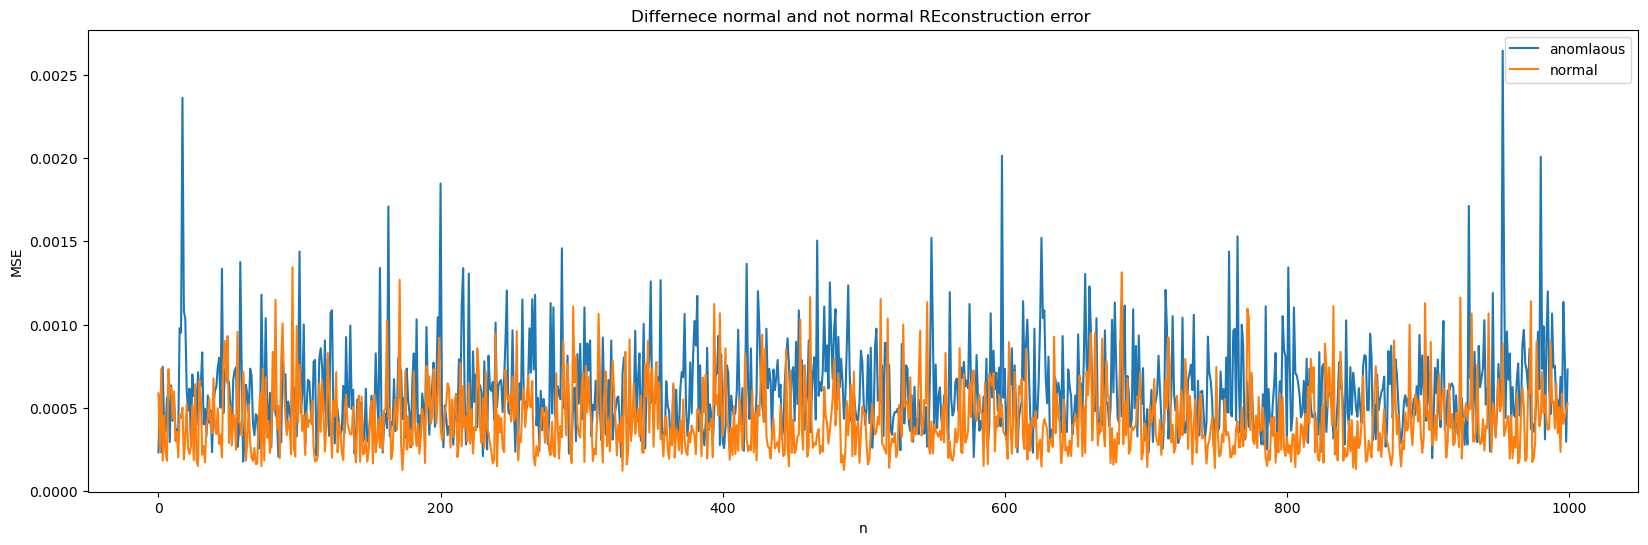

0.01738994850427175


In [81]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
y=np.arange(0,len(mse_recons_a),1)
# Create the line plot

plt.plot(y,[i[0]*i[1] for i in zip(mse_recons_a, mse_avg_a)],  label='anomlaous')
plt.plot(y,[i[0]*i[1] for i  in zip(mse_recons_n, mse_avg_n)],  label='normal')
# Add labels and title
plt.xlabel('n')
plt.ylabel('MSE')
plt.title('Differnece normal and not normal REconstruction error ')
plt.legend()
# Show the plot
plt.show()

print((np.mean([i[0]*i[1] for i in zip(mse_recons_a, mse_avg_a)])-np.mean([i[0]*i[1] for i  in zip(mse_recons_n, mse_avg_n)]))*100)

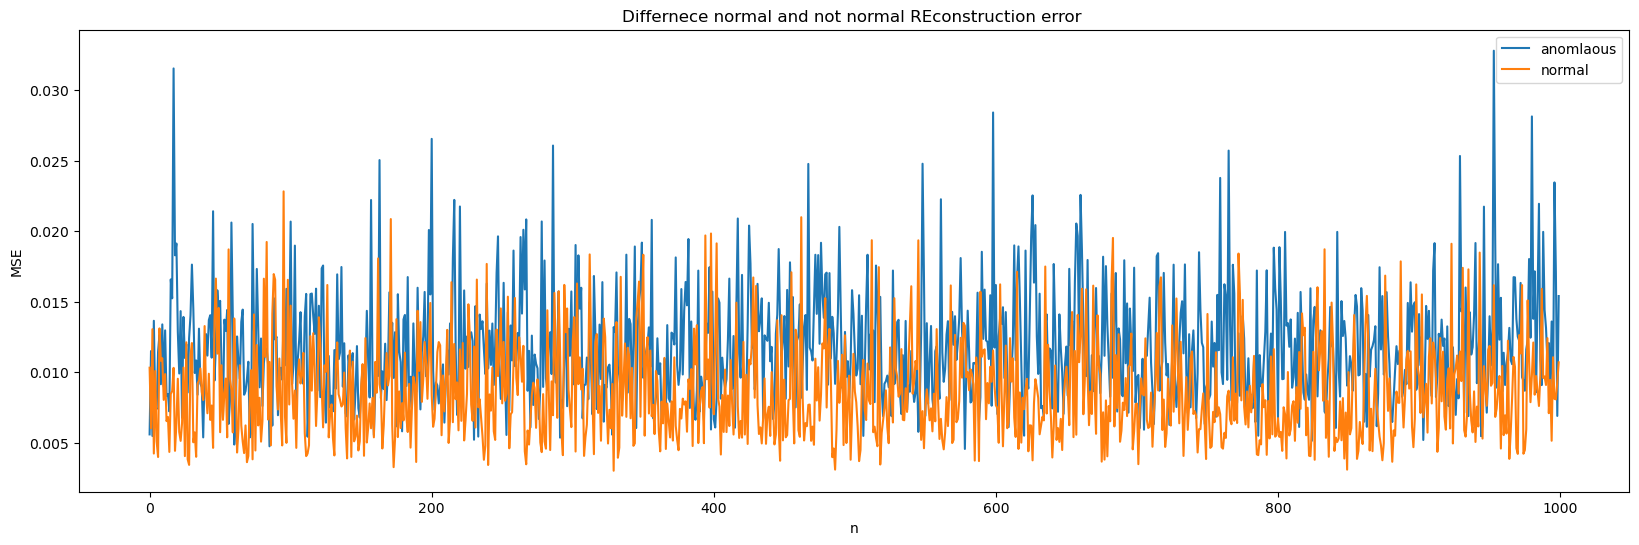

-0.31545252215969527


In [82]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
y=np.arange(0,len(mse_recons_a),1)
# Create the line plot

plt.plot(y,mse_recons_a,  label='anomlaous')
plt.plot(y,mse_recons_n,  label='normal')
# Add labels and title
plt.xlabel('n')
plt.ylabel('MSE')
plt.title('Differnece normal and not normal REconstruction error ')
plt.legend()
# Show the plot
plt.show()

print((np.mean(mse_recons_n)-np.mean(mse_recons_a))*100)

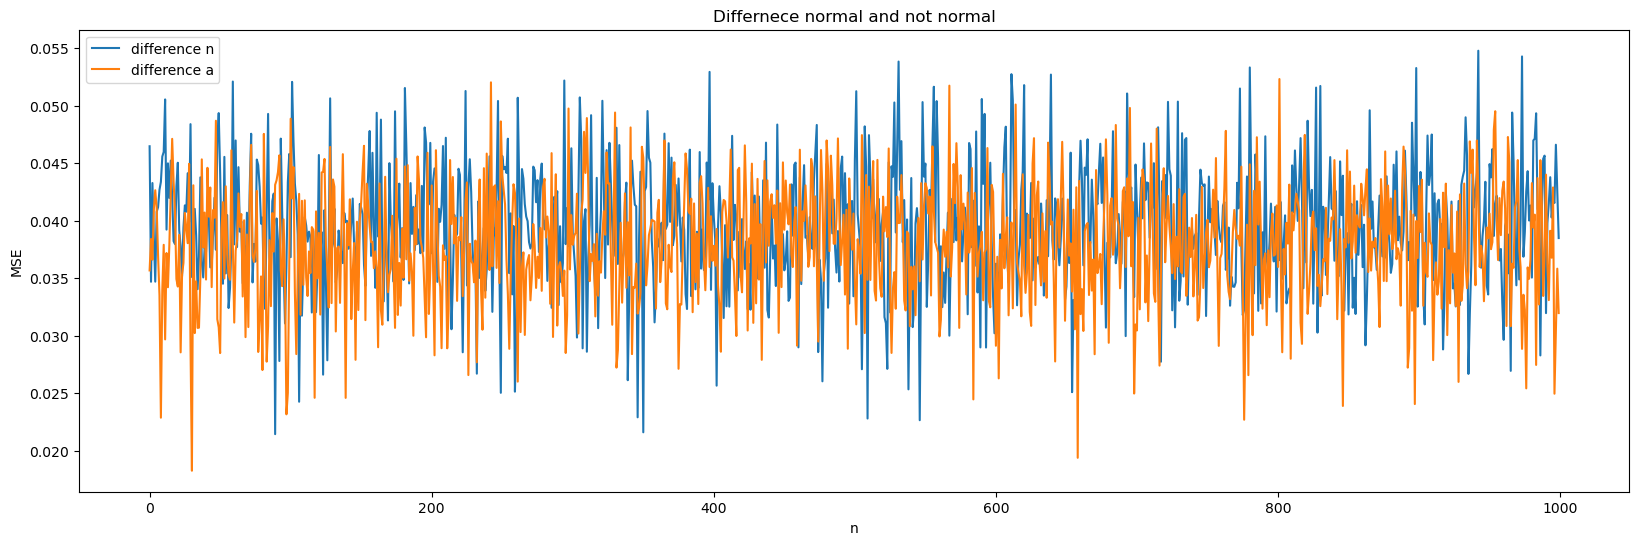

In [84]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
y=np.arange(0,len(difference_a),1)
# Create the line plot

plt.plot(y,difference_n,  label='difference n')
plt.plot(y,difference_a,  label='difference a')
# Add labels and title
plt.xlabel('n')
plt.ylabel('MSE')
plt.title('Differnece normal and not normal')
plt.legend()
# Show the plot
plt.show()

# Test on small example

In [31]:
import numpy as np

# Example data
tensor_shape = (2, 3)
num_copies = 3

# Assuming you have your actual data here
tensor_to_duplicate = np.random.rand(*tensor_shape)
duplicated_tensor = np.tile(tensor_to_duplicate, (num_copies, 1, 1))


In [32]:
duplicated_tensor

array([[[0.49688949, 0.57616709, 0.7366568 ],
        [0.25428311, 0.97729737, 0.54134048]],

       [[0.49688949, 0.57616709, 0.7366568 ],
        [0.25428311, 0.97729737, 0.54134048]],

       [[0.49688949, 0.57616709, 0.7366568 ],
        [0.25428311, 0.97729737, 0.54134048]]])

In [35]:
duplicated_tensor.shape

(3, 2, 3)

In [33]:
#
for i in range(duplicated_tensor.shape[0]):
    for j in range(duplicated_tensor.shape[1]):
        duplicated_tensor[i,j,i]=1


In [34]:
duplicated_tensor

array([[[1.        , 0.57616709, 0.7366568 ],
        [1.        , 0.97729737, 0.54134048]],

       [[0.49688949, 1.        , 0.7366568 ],
        [0.25428311, 1.        , 0.54134048]],

       [[0.49688949, 0.57616709, 1.        ],
        [0.25428311, 0.97729737, 1.        ]]])